# Data downloading, analyzing, preprocessing and saving

# Data downloading

In [ ]:
# Download the data
%%capture
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip
!pip install -U sentence-transformers

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import random

In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(21)

In [ ]:
# Load rated data. Take a split of the initial dataset
ua_base = pd.read_csv("ml-100k/ua.base",  sep="\t", header=None, names=["user_id", "item_id", "rating", "timestamp"])
ua_test = pd.read_csv("ml-100k/ua.test",  sep="\t", header=None, names=["user_id", "item_id", "rating", "timestamp"])

ua_base

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
90565,943,1047,2,875502146
90566,943,1074,4,888640250
90567,943,1188,3,888640250
90568,943,1228,3,888640275


In [ ]:
# Users and movies information
# Index is an id
users = pd.read_csv("ml-100k/u.user",  sep="|", header=None, names=["age", "gender", "occupation", "zip_code"], index_col=0)
genres = pd.read_csv("ml-100k/u.genre",sep="|", header=None, index_col=1)
movies_columns = ["movie_title", "release_date", "video_release_date", "IMDB_URL"] + genres.index.astype(str).tolist()
movies = pd.read_csv("ml-100k/u.item",sep="|", header=None, index_col=0, names=movies_columns,encoding='latin-1')

# Data analysis

## Ratings data

In [ ]:
ua_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90570 entries, 0 to 90569
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    90570 non-null  int64
 1   item_id    90570 non-null  int64
 2   rating     90570 non-null  int64
 3   timestamp  90570 non-null  int64
dtypes: int64(4)
memory usage: 2.8 MB


In [ ]:
# All users in test data exist in the train set
np.all(ua_test["user_id"].unique() == ua_base["user_id"].unique())

True

In [ ]:
# But not all items in test data exist in the train set
print("Item ids that does not exist in the train set:", *ua_test["item_id"].unique()[~np.isin(ua_test["item_id"].unique(), ua_base["item_id"].unique())])

Item ids that does not exist in the train set: 1582 1653


In [ ]:
print("All ratings are unique:", len(ua_base) == len(ua_base.drop_duplicates(["user_id", "item_id"])))

All ratings are unique: True


### Vizualization of ratings distribution

In [ ]:
ua_base["rating"].describe()

count    90570.000000
mean         3.523827
std          1.126073
min          1.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

Text(0, 0.5, 'Number of ratings')

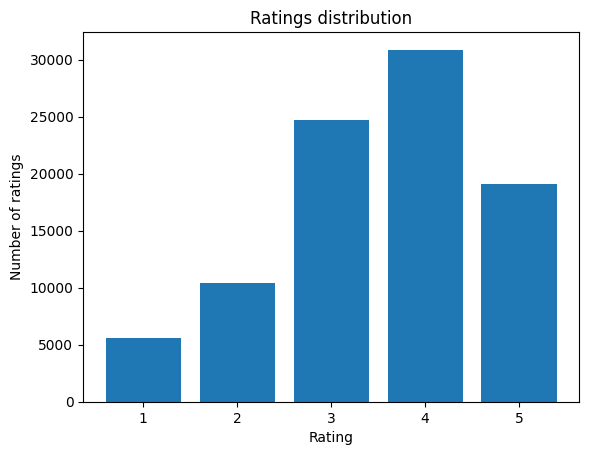

In [ ]:
# Ratings distribution on train dataset
temp_df = ua_base.groupby("rating")["user_id"].count().sort_values(ascending=False)
plt.bar(temp_df.index, temp_df.values)
plt.title("Ratings distribution")
plt.xlabel("Rating")
plt.ylabel("Number of ratings")

Text(0, 0.5, 'Number of ratings')

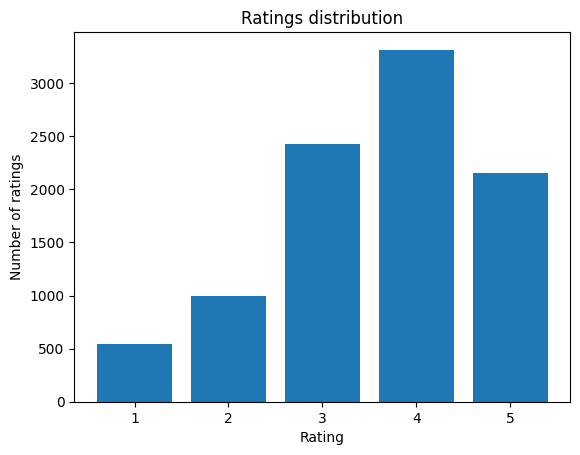

In [ ]:
# Ratings distribution on test dataset
temp_df = ua_test.groupby("rating")["user_id"].count().sort_values(ascending=False)
plt.bar(temp_df.index, temp_df.values)
plt.title("Ratings distribution")
plt.xlabel("Rating")
plt.ylabel("Number of ratings")

Text(0, 0.5, 'Number of ratings')

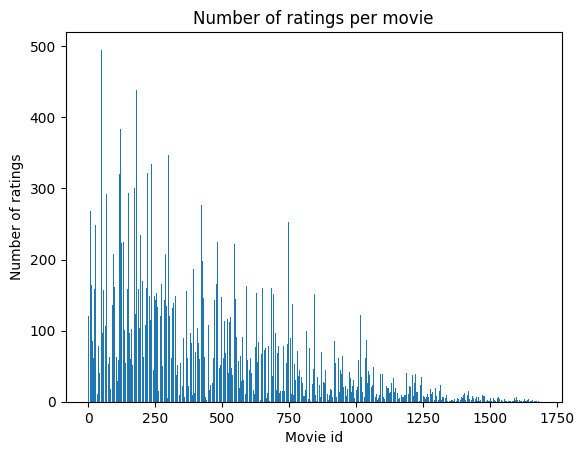

In [ ]:
temp_df = ua_base.groupby("item_id")["rating"].count().sort_values(ascending=False)
plt.bar(temp_df.index, temp_df.values)
plt.title("Number of ratings per movie")
plt.xlabel("Movie id")
plt.ylabel("Number of ratings")

<ipython-input-13-9e29eda07eaf>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(temp_df.index.astype(str))


Text(0, 0.5, 'Number of ratings')

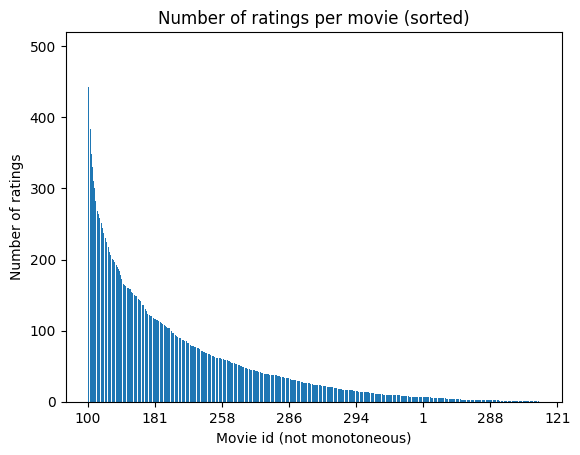

In [ ]:
temp_df = ua_base.groupby("item_id")["rating"].count().sort_values(ascending=False)
fig, ax = plt.subplots()
plt.bar(sorted(temp_df.index), temp_df.values)
ax.set_xticklabels(temp_df.index.astype(str))

plt.title("Number of ratings per movie (sorted)")
plt.xlabel("Movie id (not monotoneous)")
plt.ylabel("Number of ratings")


<ipython-input-14-fee49a8527e5>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(temp_df.index.astype(str))


Text(0, 0.5, 'Number of ratings')

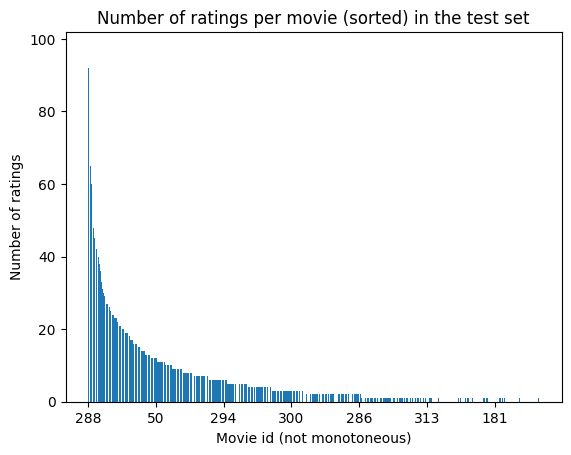

In [ ]:
temp_df = ua_test.groupby("item_id")["rating"].count().sort_values(ascending=False)
fig, ax = plt.subplots()
plt.bar(sorted(temp_df.index), temp_df.values)
ax.set_xticklabels(temp_df.index.astype(str))

plt.title("Number of ratings per movie (sorted) in the test set")
plt.xlabel("Movie id (not monotoneous)")
plt.ylabel("Number of ratings")


Show the same with respect to user

Text(0, 0.5, 'Number of ratings')

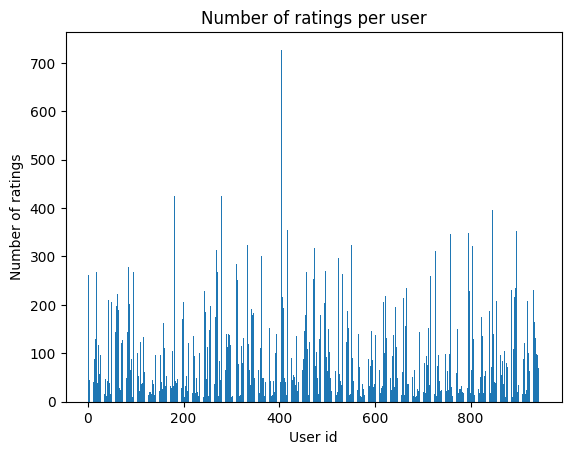

In [ ]:
temp_df = ua_base.groupby("user_id")["rating"].count().sort_values(ascending=False)
plt.bar(temp_df.index, temp_df.values)
plt.title("Number of ratings per user")
plt.xlabel("User id")
plt.ylabel("Number of ratings")

<ipython-input-16-ed22fb29f8ab>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(temp_df.index.astype(str))


Text(0, 0.5, 'Number of ratings')

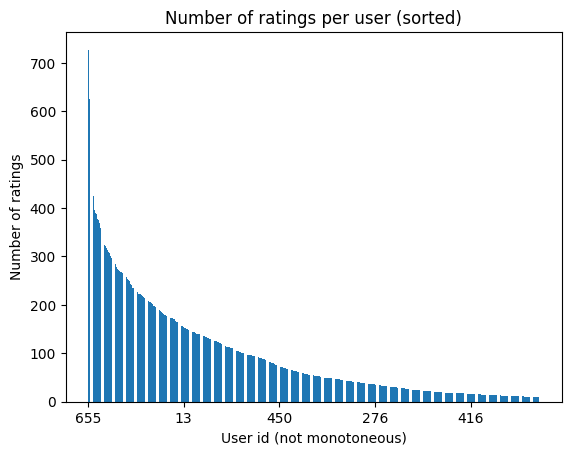

In [ ]:
temp_df = ua_base.groupby("user_id")["rating"].count().sort_values(ascending=False)
fig, ax = plt.subplots()
plt.bar(sorted(temp_df.index), temp_df.values)
ax.set_xticklabels(temp_df.index.astype(str))

plt.title("Number of ratings per user (sorted)")
plt.xlabel("User id (not monotoneous)")
plt.ylabel("Number of ratings")

<ipython-input-17-c61df6f8190d>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(temp_df.index.astype(str))


Text(0, 0.5, 'Number of ratings')

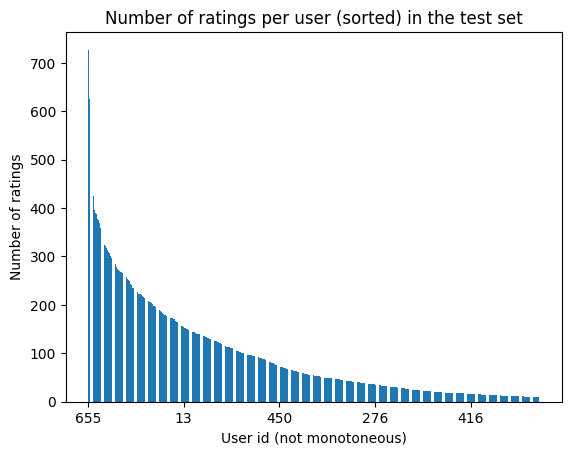

In [ ]:
temp_df = ua_base.groupby("user_id")["rating"].count().sort_values(ascending=False)
fig, ax = plt.subplots()
plt.bar(sorted(temp_df.index), temp_df.values)
ax.set_xticklabels(temp_df.index.astype(str))

plt.title("Number of ratings per user (sorted) in the test set")
plt.xlabel("User id (not monotoneous)")
plt.ylabel("Number of ratings")

## Movies

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_title         1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDB_URL            1679 non-null   object 
 4   0                   1682 non-null   int64  
 5   1                   1682 non-null   int64  
 6   2                   1682 non-null   int64  
 7   3                   1682 non-null   int64  
 8   4                   1682 non-null   int64  
 9   5                   1682 non-null   int64  
 10  6                   1682 non-null   int64  
 11  7                   1682 non-null   int64  
 12  8                   1682 non-null   int64  
 13  9                   1682 non-null   int64  
 14  10                  1682 non-null   int64  
 15  11                  1682 non-null   int64  
 16  12    

In [ ]:
# All video_release_date are nan
movies[movies["video_release_date"].notna()]

,movie_title,release_date,video_release_date,IMDB_URL,0,1,2,3,4,5,...,9,10,11,12,13,14,15,16,17,18


In [ ]:
# All movies contains release year in the title, better to differentiate it
movies[movies["movie_title"].apply(lambda x: not x.split("(")[-1][:4].isdigit()) ]

,movie_title,release_date,video_release_date,IMDB_URL,0,1,2,3,4,5,...,9,10,11,12,13,14,15,16,17,18
267,unknown,NaN,NaN,NaN,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1412,Land Before Time III: The Time of the Great Gi...,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Land%20Before...,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Only 2 movies had unknown genre
movies[movies["0"] == 1]

,movie_title,release_date,video_release_date,IMDB_URL,0,1,2,3,4,5,...,9,10,11,12,13,14,15,16,17,18
267,unknown,NaN,NaN,NaN,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1373,Good Morning (1971),4-Feb-1971,NaN,http://us.imdb.com/M/title-exact?Good%20Mornin...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Release date is in str format, reformat to datetime for easy use
movies["release_date"] = movies["release_date"].apply(lambda x: datetime.datetime.strptime(x, '%d-%b-%Y') if type(x) == str else x)

In [ ]:
print("First movie release date is", movies["release_date"].min(), "and the newest is", movies["release_date"].max())

First movie release date is 1922-01-01 00:00:00 and the newest is 1998-10-23 00:00:00


Text(0, 0.5, 'Number of movies')

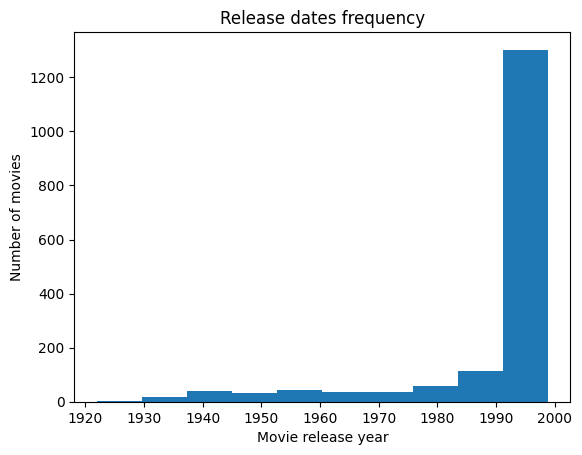

In [ ]:
movies["release_date"].hist(grid=False)

plt.title("Release dates frequency")
plt.xlabel("Movie release year")
plt.ylabel("Number of movies")

## User analysis

In [ ]:
# Zip code means post location
users["zip_code"].min(), users["zip_code"].max()

('00000', 'Y1A6B')

Text(0, 0.5, 'Number of users')

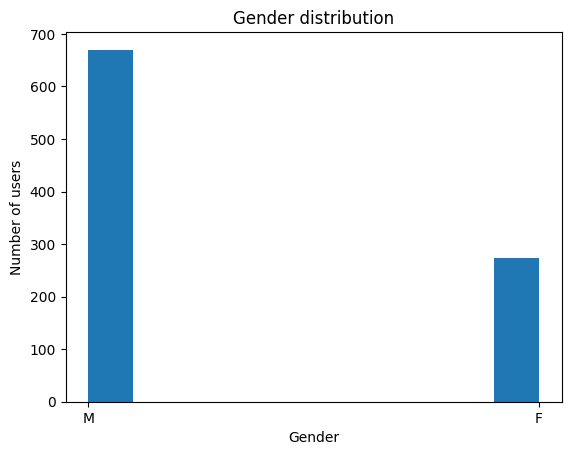

In [ ]:
# Distribution of men and women
users["gender"].hist(grid=False)

plt.title("Gender distribution")
plt.xlabel("Gender")
plt.ylabel("Number of users")

In [ ]:
users.groupby("occupation")["age"].count().sort_values()

occupation
doctor             7
homemaker          7
none               9
salesman          12
lawyer            12
retired           14
healthcare        16
entertainment     18
marketing         26
technician        27
artist            28
scientist         31
executive         32
writer            45
librarian         51
programmer        66
engineer          67
administrator     79
educator          95
other            105
student          196
Name: age, dtype: int64

Text(0, 0.5, 'Number of users')

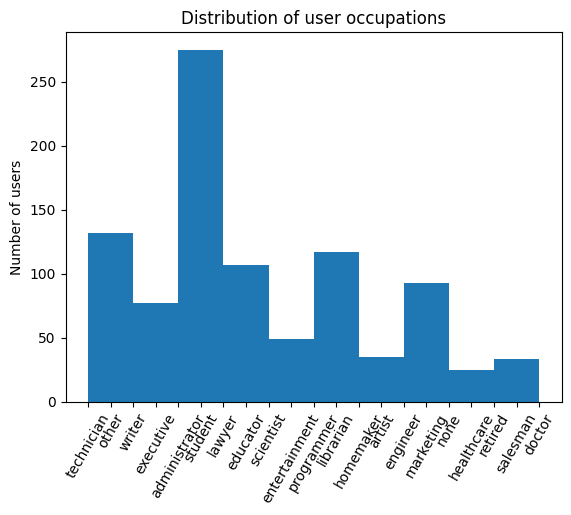

In [ ]:
# Distribution of men and women
users["occupation"].hist(xrot=60, grid=False)

plt.title("Distribution of user occupations")
plt.ylabel("Number of users")

#### Age

In [ ]:
print("Minimal user age is", users["age"].min(), ", maximal is", users["age"].max())

Minimal user age is 7 , maximal is 73


array([<Axes: title={'center': 'F'}, ylabel='Frequency'>,
       <Axes: title={'center': 'M'}, ylabel='Frequency'>], dtype=object)

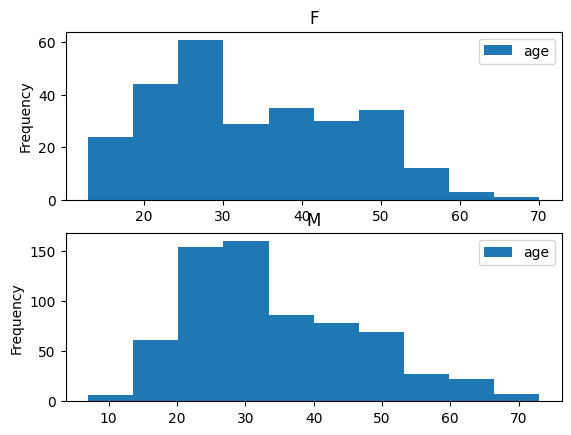

In [ ]:
# Distribution of age for men and women
users.plot.hist(by="gender")

# Data preprocessing

## Movies preprocessing

### Encode release date


In [ ]:
# Release date is in str format, reformat to datetime for easy use
movies["release_date"] = movies["release_date"].apply(lambda x: datetime.datetime.strptime(x, '%d-%b-%Y') if type(x) == str else x)

In [ ]:
# Than normalize date using standart scaler
# We are interested more in the remote of the date, but not its cycle feature

# Get number of days
movies["processed_date"] = movies["release_date"].apply(lambda x: x.toordinal() if type(x) != pd._libs.tslibs.nattype.NaTType else x)
m = movies["processed_date"].mean()
# Handle unknown dates as mean (0 after rescaling)
movies["processed_date"] = movies["processed_date"].apply(lambda x: [m] if type(x) == pd._libs.tslibs.nattype.NaTType else [x])

# scaler = StandardScaler()
scaler = MinMaxScaler()
scaler = scaler.fit(movies["processed_date"].tolist())

movies["processed_date"] = scaler.transform(movies["processed_date"].tolist())


In [ ]:
# As shown in the data analysis, video_release_date is also None, so unuseful
# Also, IMDB_URL contain links - they are hard to work with, so I will skip this information
# In the future one may incorporate additional features based on it
movies = movies.drop(["video_release_date", "IMDB_URL"], axis=1)
movies

,movie_title,release_date,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,processed_date
1,Toy Story (1995),1995-01-01,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0.950417
2,GoldenEye (1995),1995-01-01,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.950417
3,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.950417
4,Get Shorty (1995),1995-01-01,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.950417
5,Copycat (1995),1995-01-01,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0.950417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,Mat' i syn (1997),1998-02-06,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.990768
1679,B. Monkey (1998),1998-02-06,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0.990768
1680,Sliding Doors (1998),1998-01-01,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.989485
1681,You So Crazy (1994),1994-01-01,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.937406


In [ ]:
# From data analysis, only 2 films has unknown genre
# Let's drop it, so all other genres as 0 means unknown genre
movies = movies.drop("0", axis = 1)
movies.columns

Index(['movie_title', 'release_date', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       'processed_date'],
      dtype='object')

### Reformat titles as vectors

In [ ]:
from sentence_transformers import SentenceTransformer

# Load model to vectorize movies titles
sentence_transformer = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

.gitattributes:   0%|          | 0.00/968 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

unigram.json:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
# As shown in the data analysis, all movies contains release year in the title - unnedeed column
movies["movie_title"] = movies["movie_title"].apply(lambda x: "(".join(x.split("(")[:-1]) if x.split("(")[-1][:4].isdigit() else x )
# Unique datapoint
movies.loc[1412, "movie_title"] = movies.loc[1412, "movie_title"][:-11]

# Vectorize titles
movies["vector_title"] = movies["movie_title"].apply(lambda x: sentence_transformer.encode(str(x).lower()))

# Create a dataframe of this vectors
ids = [str(i) for i in range(19, 19 + len(movies.loc[1, "vector_title"]))]
X = pd.DataFrame(np.array(movies["vector_title"].tolist()), columns=ids, index=movies.index)

# Add to the initial movies set
processed_movies = movies.drop(["movie_title", "release_date", "vector_title"], axis=1)
processed_movies = pd.concat([processed_movies, X], axis=1)
# processed_movies.head()

## User preprocessing

In [ ]:
# One hot encode gender
users["gender"] = (users["gender"] == "M").astype(int)

In [ ]:
# Normalize age
# age_scaler = StandardScaler()
age_scaler = MinMaxScaler()
age_scaler = age_scaler.fit(users["age"].to_numpy().reshape(-1, 1))
users["age_norm"] = age_scaler.transform(users["age"].to_numpy().reshape(-1, 1))

In [ ]:
processed_users = users.drop(["age", "occupation", "zip_code"], axis=1)

In [ ]:
# All 0's means none of the exsisting occupancy is about user
X = pd.get_dummies(users.occupation, drop_first=False).drop(["none", "other"], axis=1)
processed_users[X.columns] = X

In [ ]:
processed_users.head()

,gender,age_norm,administrator,artist,doctor,educator,engineer,entertainment,executive,healthcare,...,lawyer,librarian,marketing,programmer,retired,salesman,scientist,student,technician,writer
1,1,0.257576,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0.696970,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0.242424,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0.257576,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0.393939,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Add ratings statistics

In [ ]:
u_base = ua_base.copy()
u_base["rating"] = u_base["rating"] - 1

In [ ]:
# Calculate mean rating given by users
mean_rates = u_base.groupby("user_id")["rating"].mean()
mean_rates = mean_rates - mean_rates.min()
mean_rates = mean_rates / mean_rates.max()
processed_users["mean_rating_user"] = processed_users.index
processed_users["mean_rating_user"] = processed_users["mean_rating_user"].apply(lambda x: mean_rates[x])
processed_users["mean_rating_user"].max()

1.0

# Preparing datasets

In [ ]:
# Calculate mean rating given for items
mean_rates = u_base.groupby("item_id")["rating"].mean()
mean_rates = mean_rates - mean_rates.min()
mean_rates = mean_rates / mean_rates.max()
processed_movies["mean_rating_m"] = processed_movies.index
processed_movies["mean_rating_m"] = processed_movies["mean_rating_m"].apply(lambda x: mean_rates[x] if x in mean_rates.index else 0)

In [ ]:
train_dataset = ua_base.merge(processed_users, left_on="user_id", right_index=True)
train_dataset = train_dataset.merge(processed_movies, left_on="item_id", right_index=True)
train_dataset = train_dataset.drop(["user_id", "item_id", "timestamp"], axis=1)
train_dataset["rating"] = train_dataset["rating"] - 1
train_dataset = train_dataset.reset_index(drop=True)
train_dataset.head()

,rating,gender,age_norm,administrator,artist,doctor,educator,engineer,entertainment,executive,...,394,395,396,397,398,399,400,401,402,mean_rating_m
0,4,1,0.257576,0,0,0,0,0,0,0,...,0.101027,-0.140487,0.164299,0.061207,0.473726,0.195189,-0.162281,-0.016356,0.557898,0.714923
1,3,0,0.696970,0,0,0,0,0,0,0,...,0.101027,-0.140487,0.164299,0.061207,0.473726,0.195189,-0.162281,-0.016356,0.557898,0.714923
2,3,1,0.530303,0,0,0,0,0,0,1,...,0.101027,-0.140487,0.164299,0.061207,0.473726,0.195189,-0.162281,-0.016356,0.557898,0.714923
3,3,1,0.696970,0,0,0,0,0,0,0,...,0.101027,-0.140487,0.164299,0.061207,0.473726,0.195189,-0.162281,-0.016356,0.557898,0.714923
4,2,1,0.606061,0,0,0,1,0,0,0,...,0.101027,-0.140487,0.164299,0.061207,0.473726,0.195189,-0.162281,-0.016356,0.557898,0.714923


In [ ]:
val_dataset = ua_test.merge(processed_users, left_on="user_id", right_index=True)
val_dataset = val_dataset.merge(processed_movies, left_on="item_id", right_index=True)
val_dataset = val_dataset.drop(["user_id", "item_id", "timestamp"], axis=1)
val_dataset["rating"] = val_dataset["rating"] - 1
val_dataset = val_dataset.reset_index(drop=True)
val_dataset = val_dataset[train_dataset.columns]
val_dataset.head()


,rating,gender,age_norm,administrator,artist,doctor,educator,engineer,entertainment,executive,...,394,395,396,397,398,399,400,401,402,mean_rating_m
0,3,1,0.257576,0,0,0,0,0,0,0,...,-0.33782,0.188377,-0.190926,-0.061149,0.389139,0.74876,-0.264567,0.365973,0.179355,0.586066
1,2,1,0.363636,0,0,0,0,0,0,0,...,-0.33782,0.188377,-0.190926,-0.061149,0.389139,0.74876,-0.264567,0.365973,0.179355,0.586066
2,2,1,0.363636,0,0,0,0,1,0,0,...,-0.33782,0.188377,-0.190926,-0.061149,0.389139,0.74876,-0.264567,0.365973,0.179355,0.586066
3,4,1,0.378788,0,1,0,0,0,0,0,...,-0.33782,0.188377,-0.190926,-0.061149,0.389139,0.74876,-0.264567,0.365973,0.179355,0.586066
4,4,0,0.545455,1,0,0,0,0,0,0,...,-0.33782,0.188377,-0.190926,-0.061149,0.389139,0.74876,-0.264567,0.365973,0.179355,0.586066


In [ ]:
train_dataset.to_csv("train_dataset.csv")
val_dataset.to_csv("val_dataset.csv")